In [1]:
import torch
import gymnasium
import sys
import tqdm
import numpy as np
import os
rocket_dir = os.path.split(os.path.abspath(os.curdir))[:-1]
rocket_src_dir = os.path.join(*rocket_dir, 'src')
rocket_dir = os.path.join(*rocket_dir)

print(f'Appending to sys.path:', [rocket_dir, rocket_src_dir])

sys.path.append(rocket_dir)
sys.path.append(rocket_src_dir)

from src.environments.frozen_env import FrozenActions, make_frozen_env
from src.agents.Mistral_agent import MistralAgent
from src.agents.LLaMa2_agent import LLaMaAgent

pygame 2.5.2 (SDL 2.28.2, Python 3.10.13)
Hello from the pygame community. https://www.pygame.org/contribute.html
Appending to sys.path: ['/mnt/llmdata/home/gbonetta/progetti/rocket', '/mnt/llmdata/home/gbonetta/progetti/rocket/src']


/mnt/llmdata/home/gbonetta/miniconda3/miniconda/envs/crafter_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/llmdata/home/gbonetta/miniconda3/miniconda/envs/crafter_env/lib/python3.10/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment FrozenLakeText-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/mnt/llmdata/home/gbonetta/miniconda3/miniconda/envs/crafter_env/lib/python3.10/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment Hanoi3Disk-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/mnt/llmdata/home/gbonetta/miniconda3/miniconda/envs/crafter_env/lib/python3.10/site-packages/gymnasium/envs/registration.py:694: U

In [2]:
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.distributions.categorical import Categorical

In [3]:
LOCAL_NUM_ENVS = 1
SEED = 1234

In [4]:
is_crafter = False 
from src.environments.minigrid_env import make_minigrid_env
runs_directory = 'runs_directory_prova'
envs = gymnasium.vector.SyncVectorEnv(
            [make_minigrid_env(
                runs_directory,
                'MiniGrid-DoorKey-8x8-v0', #'MiniGrid-Fetch-8x8-N3-v0',#'MiniGrid-DoorKey-5x5-v0', #'MiniGrid-LockedRoom-v0','MiniGrid-LavaGapS7-v0', 'MiniGrid-PutNear-8x8-N3-v0', #'MiniGrid-PutNear-8x8-N3-v0','MiniGrid-BlockedUnlockPickup-v0', 'MiniGrid-LavaCrossingS11N5-v0', 'MiniGrid-DoorKey-8x8-v0' 'MiniGrid-SimpleCrossingS11N5-v0' 'MiniGrid-LavaCrossingS9N3-v0' 'MiniGrid-SimpleCrossingS11N5-v0'
                possible_actions_list=['forward','pickup','toggle','opt_left','opt_right','opt_back'],  #left right forward pickup toggle
                fov=1,
                fixed_orientation=False,
                no_step_description=False,
                seed=1 + i *100,
                save_video=False,
                save_video_every=100,
                save_stats=False
            )
            for i in range(1)
            ])

In [5]:
observation_space = envs.single_observation_space
action_enum = envs.envs[0].action_enum
list(action_enum)

[<action_enum.forward: 'go forward'>,
 <action_enum.pickup: 'pick up'>,
 <action_enum.toggle: 'toggle'>,
 <action_enum.opt_left: 'move left'>,
 <action_enum.opt_right: 'move right'>,
 <action_enum.opt_back: 'move back'>]

In [ ]:
from huggingface_hub import login
login('<KEY>')

In [6]:

agent = MistralAgent("mistralai/Mistral-7B-Instruct-v0.2",
                        action_enum=action_enum,
                         is_lora=True, 
                         padding_side="right", 
                         gradient_ckpt=False,
                         disable_adapters_for_generation=True)
# agent = LLaMaAgent('meta-llama/Meta-Llama-3-8B', #'meta-llama/Meta-Llama-3-8B', 'meta-llama/Llama-2-7b-chat-hf'
#                         action_enum=action_enum,
#                          is_lora=True, 
#                          padding_side="right", 
#                          gradient_ckpt=False,
#                          disable_adapters_for_generation=True)
agent.critic.to('cuda')

`low_cpu_mem_usage` was None, now set to True since model is quantized.
Loading checkpoint shards: 100%|██████████| 3/3 [00:07<00:00,  2.40s/it]


trainable params: 27,262,976 || all params: 7,268,995,072 || trainable%: 0.3750583915652433


Sequential(
  (0): Linear(in_features=4096, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=1, bias=True)
)

In [7]:
agent.network.eval()
agent.critic.eval()

Sequential(
  (0): Linear(in_features=4096, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=1, bias=True)
)

In [11]:
TEMPERATURE = 'max_logit' #'max_logit'
#good prompt
#value_prompt_template= "You are an agent in a minigrid game. {} Rules:\n- you have to be 1 step far from an object to interact with it.\nWhat's the next best action? Choose among [go forward, pick up, toggle, move left, move right, move back] and output ACTION: <chosen action>\n"
value_prompt_template= "You are an agent in a minigrid game. {} Rules:\n- you have to be 1 step far from an object to interact with it.\nWhat's the next best action? Possible actions are:\n- go forward\n- pick up\n- toggle\n- move left\n- move right\n- move back\nReason about the situation and finally write ACTION: <chosen action>\n"
action_template= "ACTION: {}"

/mnt/llmdata/home/gbonetta/miniconda3/miniconda/envs/crafter_env/lib/python3.10/site-packages/minigrid/wrappers.py:62: UserWarning: WARN: A seed has been passed to `ReseedWrapper.reset` which is ignored.
  logger.warn(
/mnt/llmdata/home/gbonetta/miniconda3/miniconda/envs/crafter_env/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


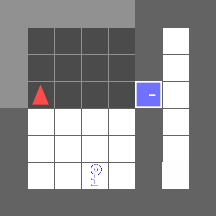

best_action=array([5])


STEP 0:

Generated sentence: Based on the information provided, the next best action would be to move back 1 step, then pick up the yellow key. After obtaining the key, move forward 4 steps to reach the locked yellow door and use the key to unlock it. Finally, move through the door and continue moving forward 4 steps to reach the goal.

ACTION: move back, pick up, move forward 4, move forward 4.</s>

Action tensor([5], device='cuda:0'), tensor([[-2.0441, -2.7597, -3.1377, -1.4053, -1.6025, -1.1485]],
       device='cuda:0').
resulted in:
next_obs.shape=(1, 216, 216, 3), reward=array([0.]), terminations=array([False]), truncations=array([False]), 
next_text_obs=array(['Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 5 steps behind you.\n- a grey wall 1 step to your right.\n- a yellow key 4 steps ahead of you to the left.\n- the goal 7 steps ahead of you to the left.\n'],
      dtype=object)



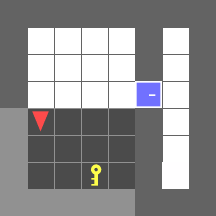

best_action=array([3])


STEP 1:

Generated sentence: Based on the information provided, the next best action would be to move left (towards the yellow key). After obtaining the key, you can then move back 4 steps to reach the locked yellow door and use the key to open it. Finally, you can move 3 steps forward to reach the goal.

ACTION: move left.</s>

Action tensor([3], device='cuda:0'), tensor([[-1.7619, -2.5620, -2.6056, -0.8988, -1.8418, -2.1923]],
       device='cuda:0').
resulted in:
next_obs.shape=(1, 216, 216, 3), reward=array([0.]), terminations=array([False]), truncations=array([False]), 
next_text_obs=array(['Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 4 steps ahead of you to the left.\n- a yellow key 3 steps ahead of you to the right.\n- the goal 6 steps ahead of you to the right.\n'],
      dtype=object)



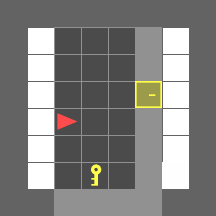

best_action=array([3])


STEP 2:

Generated sentence: Based on the information provided, the next best action would be to move right, towards the yellow key. Once you have picked up the key, you can then move left towards the locked yellow door to use the key and open it. Therefore, the sequence of actions would be: move right, pick up, move left.

ACTION: move right.</s>

Action tensor([3], device='cuda:0'), tensor([[-2.1802, -3.1207, -3.2906, -1.6045, -0.7764, -1.9341]],
       device='cuda:0').
resulted in:
next_obs.shape=(1, 216, 216, 3), reward=array([0.]), terminations=array([False]), truncations=array([False]), 
next_text_obs=array(['Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 3 steps to your right.\n- a yellow key 4 steps behind you.\n- the goal 7 steps behind you.\n'],
      dtype=object)



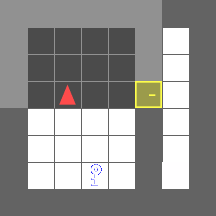

best_action=array([5])


STEP 3:

Generated sentence: Based on the information provided, the next best action would be to move back 2 steps to pick up the yellow key, and then move 5 steps back to open the yellow door. After opening the door, you can continue moving towards the goal, which is 2 steps away from the door.

ACTION: move back 2, pick up, move back 5, move forward 2.</s>

Action tensor([5], device='cuda:0'), tensor([[-1.7848, -3.7383, -3.4148, -1.6501, -1.8642, -0.8476]],
       device='cuda:0').
resulted in:
next_obs.shape=(1, 216, 216, 3), reward=array([0.]), terminations=array([False]), truncations=array([False]), 
next_text_obs=array(['Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 4 steps behind you.\n- a yellow key 3 steps ahead of you to the left.\n- the goal 6 steps ahead of you to the left.\n'],
      dtype=object)



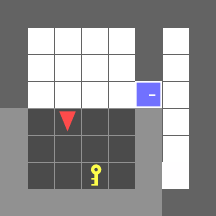

best_action=array([0])


STEP 4:

Generated sentence: Based on the information provided, the next best action would be to move left towards the yellow key. After obtaining the key, you can then move back 3 steps to interact with the locked yellow door and use the key to open it. Finally, you can move 2 steps forward to reach the goal.

ACTION: move left.</s>

Action tensor([0], device='cuda:0'), tensor([[-1.7873, -2.3220, -2.3872, -1.1120, -1.4518, -2.5312]],
       device='cuda:0').
resulted in:
next_obs.shape=(1, 216, 216, 3), reward=array([0.]), terminations=array([False]), truncations=array([False]), 
next_text_obs=array(['Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 5 steps behind you.\n- a yellow key 2 steps ahead of you to the left.\n- the goal 5 steps ahead of you to the left.\n'],
      dtype=object)



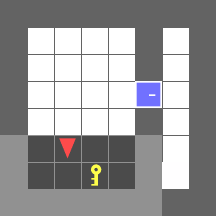

best_action=array([4])


STEP 5:

Generated sentence: Based on the information provided, the next best action would be to move left (towards the yellow key). After picking up the yellow key, you can then use it to open the yellow door and proceed towards the goal, which is 5 steps ahead and to the left. Therefore, the sequence of actions would be: move left, pick up, move left, move left, move left, and finally, move left to reach the goal.

ACTION: move left.</s>

Action tensor([4], device='cuda:0'), tensor([[-1.5608, -2.7515, -3.1617, -1.0468, -1.4035, -2.4415]],
       device='cuda:0').
resulted in:
next_obs.shape=(1, 216, 216, 3), reward=array([0.]), terminations=array([False]), truncations=array([False]), 
next_text_obs=array(['Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 6 steps behind you.\n- a grey wall 1 step ahead of you.\n- a yellow key 3 steps behind you.\n- the goal 6 steps behind you.\n'],
      dtype=objec

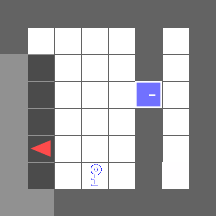

best_action=array([3])


STEP 6:

Generated sentence: Based on the information provided, the next best action would be to pick up the yellow key and then go forward to reach the locked yellow door. Once the door is unlocked using the key, you can continue moving towards the goal, which is 6 steps behind the door. Therefore, the sequence of actions would be:

ACTION: pick up > move forward > pick up the yellow key > move forward (6 steps) > interact with the locked yellow door > move forward (again, assuming the door opens into the next room or area) > move forward (remaining steps to reach the goal).</s>

Action tensor([3], device='cuda:0'), tensor([[-2.4348, -0.6998, -1.9299, -2.3263, -2.4317, -2.4654]],
       device='cuda:0').
resulted in:
next_obs.shape=(1, 216, 216, 3), reward=array([0.]), terminations=array([False]), truncations=array([False]), 
next_text_obs=array(['Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 7 s

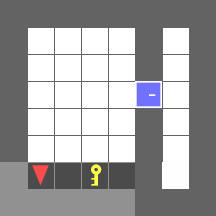

best_action=array([1])


STEP 7:

Generated sentence: Based on the information provided, the next best action would be to move left (towards the yellow key). After picking up the key, you can then move back 5 steps to reach the goal. Therefore, the sequence of actions would be: move left, pick up, move back 5 steps, and go through the goal.

ACTION: move left.</s>

Action tensor([1], device='cuda:0'), tensor([[-2.0438, -2.8454, -2.7572, -0.9927, -1.4060, -2.0161]],
       device='cuda:0').
resulted in:
next_obs.shape=(1, 216, 216, 3), reward=array([0.]), terminations=array([False]), truncations=array([False]), 
next_text_obs=array(['Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 7 steps behind you.\n- a grey wall 1 step to your right.\n- a yellow key 2 steps to your left.\n- the goal 5 steps to your left.\n- a grey wall 1 step ahead of you.\n'],
      dtype=object)



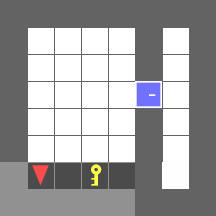

best_action=array([2])


STEP 8:

Generated sentence: 

Action tensor([2], device='cuda:0'), tensor([[-2.0438, -2.8454, -2.7572, -0.9927, -1.4060, -2.0161]],
       device='cuda:0').
resulted in:
next_obs.shape=(1, 216, 216, 3), reward=array([0.]), terminations=array([False]), truncations=array([False]), 
next_text_obs=array(['Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 7 steps behind you.\n- a grey wall 1 step to your right.\n- a yellow key 2 steps to your left.\n- the goal 5 steps to your left.\n- a grey wall 1 step ahead of you.\n'],
      dtype=object)



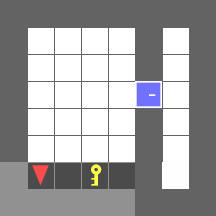

best_action=array([3])


STEP 9:

Generated sentence: 

Action tensor([3], device='cuda:0'), tensor([[-2.0438, -2.8454, -2.7572, -0.9927, -1.4060, -2.0161]],
       device='cuda:0').
resulted in:
next_obs.shape=(1, 216, 216, 3), reward=array([0.]), terminations=array([False]), truncations=array([False]), 
next_text_obs=array(['Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 6 steps ahead of you to the left.\n- a yellow key 1 step ahead of you.\n- the goal 4 steps ahead of you.\n- a grey wall 1 step to your right.\n'],
      dtype=object)



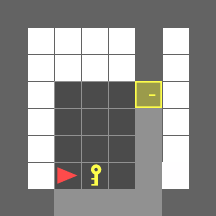

best_action=array([0])


STEP 10:

Generated sentence: Based on the information provided, the next best action would be to move forward once and then pick up the yellow key. After obtaining the key, move 5 steps to the left to reach the locked yellow door and use the key to unlock it. Finally, move 4 steps forward to reach the goal.

ACTION: move forward, then pick up, then move left 5 steps, then toggle (to open the door with the key).</s>

Action tensor([0], device='cuda:0'), tensor([[-2.4911, -0.8597, -1.6843, -2.1752, -2.2926, -2.3671]],
       device='cuda:0').
resulted in:
next_obs.shape=(1, 216, 216, 3), reward=array([0.]), terminations=array([False]), truncations=array([False]), 
next_text_obs=array(['Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 6 steps ahead of you to the left.\n- a yellow key 1 step ahead of you.\n- the goal 4 steps ahead of you.\n- a grey wall 1 step to your right.\n'],
      dtype=object)



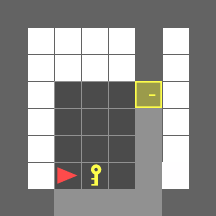

best_action=array([1])


STEP 11:

Generated sentence: 

Action tensor([1], device='cuda:0'), tensor([[-2.4911, -0.8597, -1.6843, -2.1752, -2.2926, -2.3671]],
       device='cuda:0').
resulted in:
next_obs.shape=(1, 216, 216, 3), reward=array([0.]), terminations=array([False]), truncations=array([False]), 
next_text_obs=array(['Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 6 steps ahead of you to the left.\n- the goal 4 steps ahead of you.\n- a grey wall 1 step to your right.\n and you carry a yellow key.'],
      dtype=object)



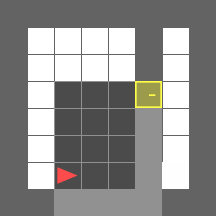

best_action=array([3])


STEP 12:

Generated sentence: Based on the information provided, the next best action would be to move left towards the yellow door and interact with it once you are one step away. Therefore, the action would be:

ACTION: move left.</s>

Action tensor([3], device='cuda:0'), tensor([[-1.7802, -3.7769, -3.0128, -0.6459, -2.0721, -2.2144]],
       device='cuda:0').
resulted in:
next_obs.shape=(1, 216, 216, 3), reward=array([0.]), terminations=array([False]), truncations=array([False]), 
next_text_obs=array(['Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 5 steps ahead of you to the right.\n- the goal 5 steps behind you.\n and you carry a yellow key.'],
      dtype=object)



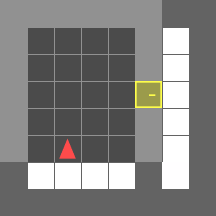

best_action=array([4])


STEP 13:

Generated sentence: Based on the information provided, the next best action would be to "go forward" towards the yellow door. Once you reach the door, you can interact with it using the yellow key to open it. After opening the door, you can continue moving forward to reach the goal.</s>

Action tensor([4], device='cuda:0'), tensor([[-0.6810, -4.4859, -3.4267, -2.0834, -1.4299, -2.4497]],
       device='cuda:0').
resulted in:
next_obs.shape=(1, 216, 216, 3), reward=array([0.]), terminations=array([False]), truncations=array([False]), 
next_text_obs=array(['Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 4 steps ahead of you to the left.\n- the goal 4 steps ahead of you to the right.\n and you carry a yellow key.'],
      dtype=object)



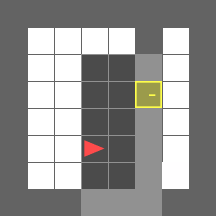

best_action=array([3])


STEP 14:

Generated sentence: Based on the information provided, the next best action would be to move left (towards the yellow door) and then use the key to toggle the door handle and open the door. Once the door is open, continue moving forward to reach the goal.

ACTION: move left, then toggle.</s>

Action tensor([3], device='cuda:0'), tensor([[-1.7024, -3.4634, -4.5301, -0.9209, -1.4199, -1.9969]],
       device='cuda:0').
resulted in:
next_obs.shape=(1, 216, 216, 3), reward=array([0.]), terminations=array([False]), truncations=array([False]), 
next_text_obs=array(['Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 3 steps ahead of you to the right.\n- the goal 5 steps behind you.\n and you carry a yellow key.'],
      dtype=object)



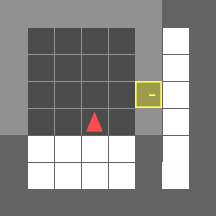

best_action=array([3])


STEP 15:

Generated sentence: Based on the information provided, the next best action would be to move 2 steps to the right, bringing yourself to a position where you are 1 step away from the yellow door. Once you are in this position, you can interact with the door by using the yellow key to open it. After opening the door, you can continue moving towards the goal, which is 5 steps behind your current position. Therefore, the next best action is:

ACTION: move right (twice)</s>

Action tensor([3], device='cuda:0'), tensor([[-1.5321, -2.4710, -2.3780, -1.6374, -1.3325, -1.9080]],
       device='cuda:0').
resulted in:
next_obs.shape=(1, 216, 216, 3), reward=array([0.]), terminations=array([False]), truncations=array([False]), 
next_text_obs=array(['Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 4 steps behind you.\n- the goal 6 steps behind you.\n and you carry a yellow key.'],
      dtype=object)



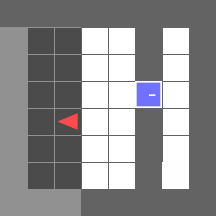

best_action=array([0])


STEP 16:

Generated sentence: Based on the information provided, the next best action would be to move forward twice (once to be one step away from the locked yellow door and then again to be in a position to interact with the goal). Therefore, the action would be:

ACTION: move forward twice.</s>

Action tensor([0], device='cuda:0'), tensor([[-1.1593, -1.6325, -2.3284, -2.3725, -2.4372, -1.5477]],
       device='cuda:0').
resulted in:
next_obs.shape=(1, 216, 216, 3), reward=array([0.]), terminations=array([False]), truncations=array([False]), 
next_text_obs=array(['Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 5 steps behind you.\n- a grey wall 1 step ahead of you.\n- the goal 7 steps behind you.\n and you carry a yellow key.'],
      dtype=object)



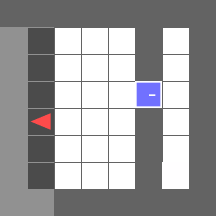

best_action=array([4])


STEP 17:

Generated sentence: Based on the information provided, the next best action would be to move back 1 step, as I need to be exactly 1 step away from the locked yellow door to use the key to open it. Therefore, the action would be:

ACTION: move back.</s>

Action tensor([4], device='cuda:0'), tensor([[-1.4064, -3.4729, -3.5292, -1.6977, -1.9069, -1.0134]],
       device='cuda:0').
resulted in:
next_obs.shape=(1, 216, 216, 3), reward=array([0.]), terminations=array([False]), truncations=array([False]), 
next_text_obs=array(['Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step to your left.\n- a locked yellow door 4 steps to your right.\n- the goal 8 steps behind you.\n and you carry a yellow key.'],
      dtype=object)



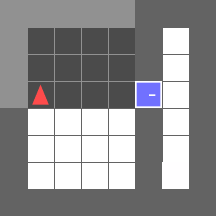

best_action=array([3])


STEP 18:

Generated sentence: Based on the information provided, the next best action would be to move left (towards the grey wall) and then use the key to interact with the object that is 1 step away from you after moving left. This could be the wall or another object, but since the information does not specify, it's an assumption that the wall is the only object in that location. Once you have interacted with the wall or the object, you can then move towards the yellow door with the key to unlock it and continue on your mission to reach the goal.

ACTION: move left.</s>

Action tensor([3], device='cuda:0'), tensor([[-1.9630, -2.9862, -3.5271, -0.6963, -1.7472, -2.2348]],
       device='cuda:0').
resulted in:
next_obs.shape=(1, 216, 216, 3), reward=array([0.]), terminations=array([False]), truncations=array([False]), 
next_text_obs=array(['Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a grey wall 1 step ahead of you.

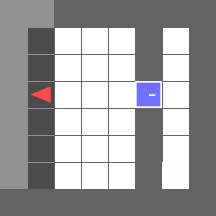

best_action=array([3])


STEP 19:

Generated sentence: Based on the information provided, the next best action would be to go forward. This allows you to get closer to the grey wall and potentially interact with the door or the goal once you have reached the appropriate distance. The key can be used to open the yellow door once you are in the correct position, but that is not the current goal. Therefore, moving forward is the most logical action at this time.

ACTION: go forward.</s>

Action tensor([3], device='cuda:0'), tensor([[-0.4745, -2.8620, -3.1797, -2.4035, -2.2272, -2.5153]],
       device='cuda:0').
resulted in:
next_obs.shape=(1, 216, 216, 3), reward=array([0.]), terminations=array([False]), truncations=array([False]), 
next_text_obs=array(['Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a locked yellow door 5 steps behind you.\n- a grey wall 1 step to your right.\n- the goal 7 steps ahead of you to the left.\n and you carry a yello

In [12]:
next_obs, infos = envs.reset(seed=SEED)
next_obs = torch.Tensor(next_obs).to('cuda')
next_text_obs = infos.get('obs', [None]*LOCAL_NUM_ENVS)

for step in range(20):
    with torch.no_grad():
        res = agent.get_action_and_value(next_obs, 
                                                 value_prompt_template=value_prompt_template,
                                                 action_template=action_template,
                                                 text_description=next_text_obs, 
                                                 temperature=TEMPERATURE, 
                                                 generate_actions=True,
                                                 normalization_by_words=False,
                                                 advanced_action_matching=False)
        action, logprob, value = res['action'], res['log_prob'], res['values']

        to_pil = transforms.ToPILImage()
        pil_image = to_pil(transforms.functional.invert(next_obs[0].permute(2, 0, 1)))
        display(pil_image)

        #best_action_by_logit = torch.argmax(res['action_logits']).cpu().numpy()
        #best_action_by_logit = np.array([best_action_by_logit])
        best_action = action.cpu().numpy()
        print(f"{best_action=}")
        next_obs, reward, terminations, truncations, infos = envs.step(best_action)
        next_text_obs = infos.get('obs', [None]*LOCAL_NUM_ENVS)
        
        print(f"\n\nSTEP {step}:")
        #print(f"\nPrompts - {res.get('prompts', 'no prompts')}")
        print(f"\nGenerated sentence: {res['generated_action']}")
        print(f"\nAction {action}, {res['action_logits']}.\nresulted in:\n{next_obs.shape=}, {reward=}, {terminations=}, {truncations=}, \n{next_text_obs=}\n")     

        next_obs = torch.Tensor(next_obs).to('cuda')

In [10]:
agent.action_generation_cache

{"<s>[INST] You are an agent in a minigrid game. Your mission is:\n\nuse the key to open the door and then get to the goal.\n\nYou see:\n- a yellow key 6 steps ahead of you to the right.\n- a locked yellow door 7 steps ahead of you to the right.\n- a grey wall 1 step to your left.\n- the goal 5 steps to your right.\n- a grey wall 1 step behind you.\n Rules:\n- you have to be 1 step far from an object to interact with it.\nWhat's the next best action? Choose among [go forward, pick up, toggle, move left, move right, move back] and output ACTION: <chosen action>\n [/INST]": (['Based on the information provided, the next best action would be to  go forward (ACTION:  go forward). This will allow you to get closer to the yellow key and the yellow door, bringing you one step closer to completing your mission.</s>',
   'Based on the information provided, the next best action would be to  pick up (ACTION:  pick up). This will allow you to get closer to the yellow key and the yellow door, bring

In [ ]:
message = """You are playing a minigrid game. A smart expert player that wants to help you tells you the following:
\"\"\"
To complete the mission, the single next best action would be to move forward 1 step towards the yellow key. This allows you to pick up the key in the next action.

Reasoning:
1. The key is necessary to open the door, and it's located closer to the current position than the door or the goal.
2. Since you can't pass through walls, you can't reach the key or the door directly.
3. Therefore, the best action is to move closer to the key, enabling you to pick it up in the next action.

ANSWER: <move forward 1 step>
\"\"\"
Given that the possible actions in the game are ['turn left', 'turn right', 'move forward', 'pick up', 'toggle'], which one would you choose?
"""

In [ ]:
message = """I am an agent in a minigrid game. Rules of the game are:
-You need to be exactly 1 step from any object (e.g. key, door,...) in order to toggle it or pick it up.
-You cannot pass through walls. 

My mission is:

use the key to open the door and then get to the goal.

I see:
- a grey wall 1 step to my right.
- a yellow key 3 steps to my left.
- a locked yellow door 2 steps behind me.
- the goal 6 steps behind me.

 What's the next best action i should do?"""


In [ ]:

message = """You are an agent in a minigrid game. Rules are:
-You need to be exactly 1 step from any object (e.g. key, door,...) in order to toggle it or pick it up.
-You cannot pass through walls. Your mission is:

use the key to open the door and then get to the goal.

You see:
- a grey wall 1 step to your right.
- a yellow key 3 steps to your left.
- a locked yellow door 2 steps behind you.
- the goal 6 steps behind you.

 What's the single next best action? Reason step-by-step and output BEST ACTION: <action>"""


In [ ]:

conversation = [{"role": "user", "content": message}]
input_ids = agent.tokenizer.apply_chat_template(conversation, tokenize=False)
print(input_ids)
context_prompt = agent.tokenizer(input_ids, return_tensors="pt", padding=True).to(agent.network.device)
result = agent.network.generate(**context_prompt, max_new_tokens=60)
print(agent.tokenizer.batch_decode(result))

In [ ]:
messages = [
    {"role": "user", "content": "What is your favourite condiment?"},
    {"role": "assistant", "content": "Well, I'm quite partial to a good squeeze of fresh lemon juice. It adds just the right amount of zesty flavour to whatever I'm cooking up in the kitchen!"},
    {"role": "user", "content": "Do you have mayonnaise recipes?"}
]

model_inputs = agent.tokenizer.apply_chat_template(messages, tokenize=False)
print(model_inputs)


In [ ]:

message = """You are an agent in a minigrid game. The objective is to reach the goal by using a key to open a door. Your current position is 5 steps away from the goal, and there is a key 4 steps away from you and a locked door 5 steps away. There is a grey wall 1 step to the right and an empty space to the left. What action should you take next to accomplish your mission? (Choose from: turn left, turn right, go forward, pick up, toggle.)"""
conversation = [{"role": "user", "content": message}]
input_ids = agent.tokenizer.apply_chat_template(conversation, tokenize=False)
context_prompt = agent.tokenizer(input_ids, return_tensors="pt", padding=True)
result = agent.network.generate(**context_prompt, max_new_tokens=60)
print(agent.tokenizer.batch_decode(result))

In [ ]:
print(f"{len(observations_dataset)}")
for k,v in observations_dataset.items():
    #print(f"prompt: {k}\n")
    message = k
    context_prompt = agent.tokenizer(message, return_tensors="pt", padding=True)
    result = agent.network.generate(**context_prompt, max_new_tokens=200)
    print(f"generation: {agent.tokenizer.batch_decode(result)[0]}\n")

In [ ]:
print(k[:-8] + " Be brief on your choice explanation.")